# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from lakemodel_function import lake_problem

from ema_workbench import (SequentialEvaluator, Model, RealParameter,  
                           ScalarOutcome, ema_logging, MultiprocessingEvaluator,
                           perform_experiments, Policy)
from ema_workbench.analysis import cart, prim, dimensional_stacking, feature_scoring, RuleInductionType
ema_logging.log_to_stderr(ema_logging.INFO);
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.evaluators import SOBOL

In [2]:
#instantiate the model
model = Model('LakeProblem', function=lake_problem)
model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45), RealParameter('mean', 0.01, 0.05), 
                       RealParameter('stdev', 0.001, 0.005), RealParameter('delta', 0.93, 0.99), 
                       RealParameter('q', 2, 4.5)]

# set levers, one for each time step
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                range(model.time_horizon)] # we use time_horizon here

#specify outcomes 
model.outcomes = [ScalarOutcome('max_P'), ScalarOutcome('utility'), ScalarOutcome('inertia'), ScalarOutcome('reliability')]

In [8]:
policies = [Policy('0', **{l.name: 0 for l in model.levers }), 
            Policy('0.05', **{l.name: 0.05 for l in model.levers }),
            Policy('0.1', **{l.name: 0.1 for l in model.levers })]

### Release Policy 0

In [25]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=policies[0],
                                               uncertainty_sampling='sobol')

experiments0, outcomes0 = sa_results

problem0 = get_SALib_problem(model.uncertainties)
Si0 = sobol.analyze(problem0, outcomes0['reliability'],
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [26]:
experiments0

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.176904,0.935801,0.030742,3.691895,0.002121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72000,0,LakeProblem
1,0.417529,0.935801,0.030742,3.691895,0.002121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72001,0,LakeProblem
2,0.176904,0.932754,0.030742,3.691895,0.002121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72002,0,LakeProblem
3,0.176904,0.935801,0.045977,3.691895,0.002121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72003,0,LakeProblem
4,0.176904,0.935801,0.030742,3.252441,0.002121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72004,0,LakeProblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.357544,0.966709,0.029395,3.075439,0.002346,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83995,0,LakeProblem
11996,0.357544,0.951123,0.015371,3.075439,0.002346,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83996,0,LakeProblem
11997,0.357544,0.951123,0.029395,3.229248,0.002346,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83997,0,LakeProblem
11998,0.357544,0.951123,0.029395,3.075439,0.004209,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83998,0,LakeProblem


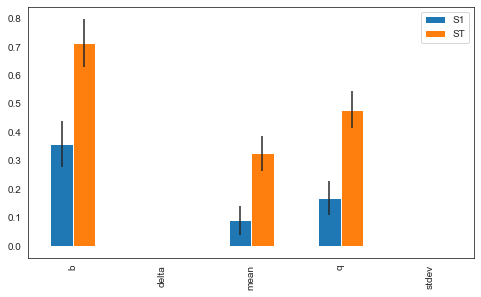

In [27]:
scores_filtered0 = {k:Si0[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si0_df = pd.DataFrame(scores_filtered0, index=problem0['names'])

sns.set_style('white')
fig, ax0 = plt.subplots(1)

indices0 = Si0_df[['S1','ST']]
err0 = Si0_df[['S1_conf','ST_conf']]

indices0.plot.bar(yerr=err0.values.T,ax=ax0)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### Release Policy 0.05

In [30]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=policies[1],
                                               uncertainty_sampling='sobol')

experiments005, outcomes005 = sa_results

problem005 = get_SALib_problem(model.uncertainties)
Si005 = sobol.analyze(problem005, outcomes005['reliability'],
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [31]:
experiments005

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.176904,0.935801,0.030742,3.691895,0.002121,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,96000,0.05,LakeProblem
1,0.417529,0.935801,0.030742,3.691895,0.002121,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,96001,0.05,LakeProblem
2,0.176904,0.932754,0.030742,3.691895,0.002121,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,96002,0.05,LakeProblem
3,0.176904,0.935801,0.045977,3.691895,0.002121,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,96003,0.05,LakeProblem
4,0.176904,0.935801,0.030742,3.252441,0.002121,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,96004,0.05,LakeProblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.357544,0.966709,0.029395,3.075439,0.002346,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,107995,0.05,LakeProblem
11996,0.357544,0.951123,0.015371,3.075439,0.002346,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,107996,0.05,LakeProblem
11997,0.357544,0.951123,0.029395,3.229248,0.002346,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,107997,0.05,LakeProblem
11998,0.357544,0.951123,0.029395,3.075439,0.004209,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,107998,0.05,LakeProblem


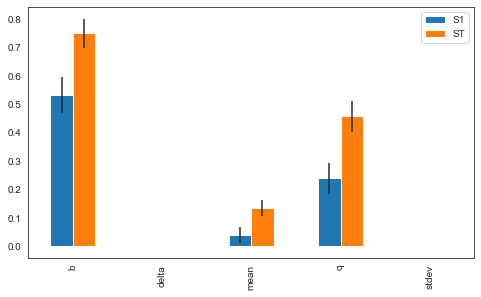

In [32]:
scores_filtered005 = {k:Si005[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si005_df = pd.DataFrame(scores_filtered005, index=problem005['names'])

sns.set_style('white')
fig, ax005 = plt.subplots(1)

indices005 = Si005_df[['S1','ST']]
err005 = Si005_df[['S1_conf','ST_conf']]

indices005.plot.bar(yerr=err005.values.T,ax=ax005)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### Release Policy 0.1

In [33]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=policies[2],
                                               uncertainty_sampling='sobol')

experiments01, outcomes01 = sa_results

problem01 = get_SALib_problem(model.uncertainties)
Si01 = sobol.analyze(problem01, outcomes01['reliability'],
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [34]:
experiments01

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.176904,0.935801,0.030742,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,108000,0.1,LakeProblem
1,0.417529,0.935801,0.030742,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,108001,0.1,LakeProblem
2,0.176904,0.932754,0.030742,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,108002,0.1,LakeProblem
3,0.176904,0.935801,0.045977,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,108003,0.1,LakeProblem
4,0.176904,0.935801,0.030742,3.252441,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,108004,0.1,LakeProblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.357544,0.966709,0.029395,3.075439,0.002346,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,119995,0.1,LakeProblem
11996,0.357544,0.951123,0.015371,3.075439,0.002346,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,119996,0.1,LakeProblem
11997,0.357544,0.951123,0.029395,3.229248,0.002346,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,119997,0.1,LakeProblem
11998,0.357544,0.951123,0.029395,3.075439,0.004209,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,119998,0.1,LakeProblem


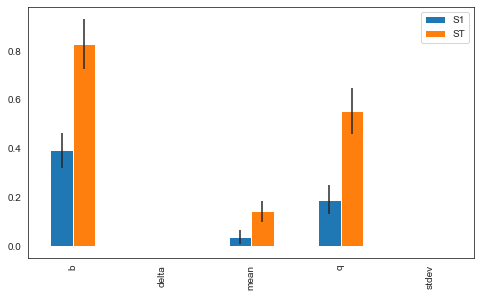

In [35]:
scores_filtered01 = {k:Si01[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si01_df = pd.DataFrame(scores_filtered01, index=problem01['names'])

sns.set_style('white')
fig, ax01 = plt.subplots(1)

indices01 = Si01_df[['S1','ST']]
err01 = Si01_df[['S1_conf','ST_conf']]

indices01.plot.bar(yerr=err01.values.T,ax=ax01)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

**The sensitivities change depending on the release policy.**

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


### All Policies

##### Feature scoring from Sobol

In [36]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=policies,
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [39]:
cleanedexperiments = experiments.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
cleanedexperiments

,b,delta,stdev,q,mean,policy
0,0.176904,0.935801,0.002121,3.691895,0.030742,0
1,0.417529,0.935801,0.002121,3.691895,0.030742,0
2,0.176904,0.932754,0.002121,3.691895,0.030742,0
3,0.176904,0.935801,0.002121,3.691895,0.045977,0
4,0.176904,0.935801,0.002121,3.252441,0.030742,0
...,...,...,...,...,...,...
35995,0.357544,0.966709,0.002346,3.075439,0.029395,0.1
35996,0.357544,0.951123,0.002346,3.075439,0.015371,0.1
35997,0.357544,0.951123,0.002346,3.229248,0.029395,0.1
35998,0.357544,0.951123,0.004209,3.075439,0.029395,0.1


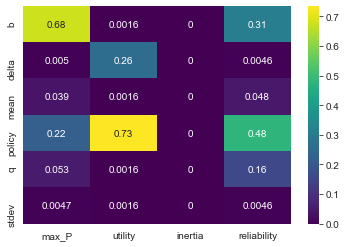

In [40]:
x = cleanedexperiments
y = outcomes

#generating feature-score for all policies and all outcomes of interest
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

From the results, when we include all 3 policies, we see that max_P is mostly influenced by b, while utility and reliability are highly driven by the policy. The effect of the uncertainties in all parameters is unknown to inertia.

In [52]:
rel = outcomes['reliability']<0.5
fs, alg = feature_scoring.get_ex_feature_scores(x, rel, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
policy,0.463520
b,0.309422
q,0.160203
mean,0.054220
stdev,0.006419
delta,0.006217


In [63]:
maxP = outcomes['max_P']<0.8
fs, alg = feature_scoring.get_ex_feature_scores(x, maxP, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
policy,0.449135
b,0.322661
q,0.159566
mean,0.056060
stdev,0.006352
delta,0.006226


In [61]:
util = outcomes['utility']<0.8
fs, alg = feature_scoring.get_ex_feature_scores(x, util, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
policy,0.507451
delta,0.472866
stdev,0.005171
b,0.004973
q,0.004868
mean,0.004672


In [62]:
iner = outcomes['inertia']<0.5
fs, alg = feature_scoring.get_ex_feature_scores(x, iner, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
b,0.0
delta,0.0
stdev,0.0
q,0.0
mean,0.0
policy,0.0


Here we ran extra trees feature scoring on a binary vector for reliability. The b parameter is still the most important, similar to in the previous feature scoring. But the introduction of the binary classification now also shows that stdev is slightly more important than delta, while previously the holds the same level of influence to reliability. The order of influence level of all parameters to the rest outcomes of interest resulted from the extra trees feature scoring are align with the previous feature scoring, except for max_P. From the extra trees feature scoring, the parameter policy is the most important, while in the previous feature scoring b is the most important.

##### Feature scoring from LHS

In [53]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=12000, policies=policies,
                                               uncertainty_sampling='lhs')

experimentsLHS, outcomesLHS = sa_results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [54]:
cleanedexperimentsLHS = experimentsLHS.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
cleanedexperimentsLHS

,b,delta,stdev,q,mean,policy
0,0.269532,0.948927,0.004479,2.827085,0.046222,0
1,0.446546,0.937169,0.002866,2.304475,0.028152,0
2,0.432252,0.980365,0.002903,3.071385,0.010804,0
3,0.273055,0.988037,0.002118,4.252738,0.034848,0
4,0.291994,0.975683,0.003572,2.943386,0.012987,0
...,...,...,...,...,...,...
35995,0.325471,0.931465,0.004068,2.244949,0.048261,0.1
35996,0.158321,0.988622,0.003260,3.099390,0.030645,0.1
35997,0.232518,0.951327,0.001067,4.425826,0.027190,0.1
35998,0.123263,0.986009,0.001617,3.291994,0.034455,0.1


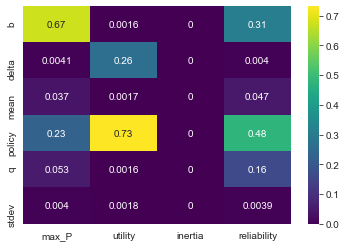

In [55]:
xLHS = cleanedexperimentsLHS
yLHS = outcomesLHS

#generating feature-score for all policies and all outcomes of interest
fsLHS = feature_scoring.get_feature_scores_all(xLHS, yLHS)
sns.heatmap(fsLHS, cmap='viridis', annot=True)
plt.show()

In [56]:
relLHS = outcomesLHS['reliability']<0.5
fsLHS, algLHS = feature_scoring.get_ex_feature_scores(xLHS, relLHS, mode=RuleInductionType.CLASSIFICATION)
fsLHS.sort_values(ascending=False, by=1)

,1
0,
policy,0.474014
b,0.303456
q,0.160663
mean,0.051170
stdev,0.005395
delta,0.005302


In [57]:
maxPLHS = outcomesLHS['max_P']<0.8
fsLHS, algLHS = feature_scoring.get_ex_feature_scores(xLHS, maxPLHS, mode=RuleInductionType.CLASSIFICATION)
fsLHS.sort_values(ascending=False, by=1)

,1
0,
policy,0.455728
b,0.313574
q,0.165437
mean,0.054069
stdev,0.005631
delta,0.005561


In [58]:
utilLHS = outcomesLHS['utility']<0.8
fsLHS, algLHS = feature_scoring.get_ex_feature_scores(xLHS, utilLHS, mode=RuleInductionType.CLASSIFICATION)
fsLHS.sort_values(ascending=False, by=1)

,1
0,
policy,0.515937
delta,0.467873
b,0.004233
q,0.004053
mean,0.004032
stdev,0.003872


In [59]:
inerLHS = outcomesLHS['inertia']<0.5
fsLHS, algLHS = feature_scoring.get_ex_feature_scores(xLHS, inerLHS, mode=RuleInductionType.CLASSIFICATION)
fsLHS.sort_values(ascending=False, by=1)

,1
0,
b,0.0
delta,0.0
stdev,0.0
q,0.0
mean,0.0
policy,0.0


When using LHS as sampling method, the order of influence level of the parameters resulted from previous feature scoring and the extra trees feature scoring  are different except for the 'reliability' (and inertia).

### Release Policy 0

##### Feature scoring from Sobol

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


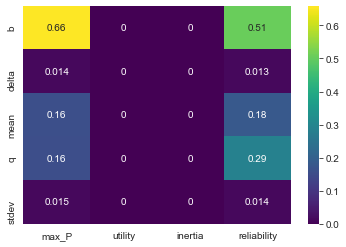

In [66]:
x0 = experiments0.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
y0 = outcomes0

fs0 = feature_scoring.get_feature_scores_all(x0, y0)
sns.heatmap(fs0, cmap='viridis', annot=True)
plt.show()

When we set the decision release as 0, we see that max_P and reliability is mostly influenced by b. The effect of the uncertainties in all parameters is unknown to utility and inertia.

##### Feature scoring from LHS

In [67]:
#re-run the experiments but now with LHS
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=12000, policies=policies[0], uncertainty_sampling='lhs')

experiments0LHS, outcomes0LHS = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


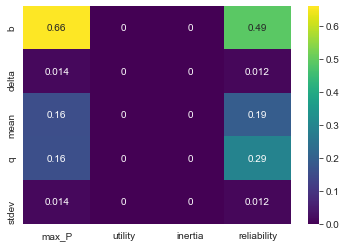

In [68]:
x0LHS = experiments0LHS.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
y0LHS = outcomes0LHS

fs0LHS = feature_scoring.get_feature_scores_all(x0LHS, y0LHS)
sns.heatmap(fs0LHS, cmap='viridis', annot=True)
plt.show()

##### Confidence Interval from LHS

In [69]:
Si0_2 = sobol.analyze(problem0, outcomes0LHS['reliability'], calc_second_order=True, print_to_console=False)

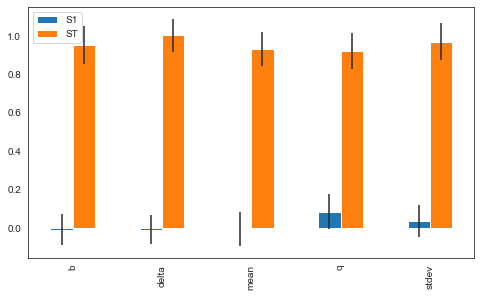

In [70]:
scores_filtered0_2 = {k:Si0_2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si0_2_df = pd.DataFrame(scores_filtered0_2, index=problem0['names'])

sns.set_style('white')
fig, ax0_2 = plt.subplots(1)

indices0_2 = Si0_2_df[['S1','ST']]
err0_2 = Si0_2_df[['S1_conf','ST_conf']]

indices0_2.plot.bar(yerr=err0_2.values.T,ax=ax0_2)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### Release Policy 0.05

##### Feature scoring from Sobol

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


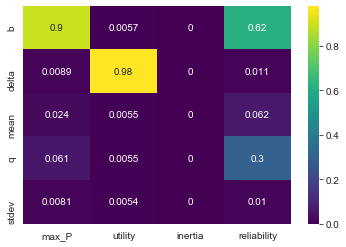

In [71]:
x005 = experiments005.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
y005 = outcomes005

fs005 = feature_scoring.get_feature_scores_all(x005, y005)
sns.heatmap(fs005, cmap='viridis', annot=True)
plt.show()

When the decision releases are set as 0.05, we see that max_P is primarily influenced by b, while utility is highly driven by delta. Reliability is mostly influenced by b as well, while the effect of the uncertainties in all parameters is unknown to inertia.

##### Feature scoring from LHS

In [72]:
#re-run the experiments but now with LHS
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=12000, policies=policies[1], uncertainty_sampling='lhs')

experiments005LHS, outcomes005LHS = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


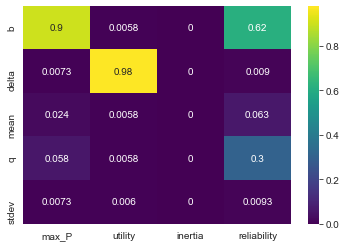

In [73]:
x005LHS = experiments005LHS.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
y005LHS = outcomes005LHS

fs005LHS = feature_scoring.get_feature_scores_all(x005LHS, y005LHS)
sns.heatmap(fs005LHS, cmap='viridis', annot=True)
plt.show()

##### Confidence Interval from LHS

In [74]:
Si005_2 = sobol.analyze(problem005, outcomes005['reliability'],
                   calc_second_order=True, print_to_console=False)

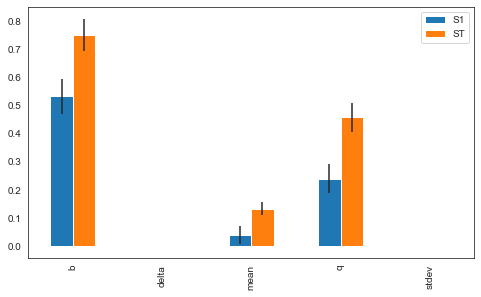

In [75]:
scores_filtered005_2 = {k:Si005_2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si005_2_df = pd.DataFrame(scores_filtered005_2, index=problem005['names'])

sns.set_style('white')
fig, ax005_2 = plt.subplots(1)

indices005_2 = Si005_2_df[['S1','ST']]
err005_2 = Si005_2_df[['S1_conf','ST_conf']]

indices005_2.plot.bar(yerr=err005_2.values.T,ax=ax005_2)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### Release Policy 0.1

##### Feature scoring from Sobol

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


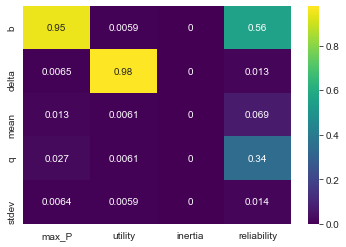

In [76]:
x01 = experiments01.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
y01 = outcomes01

fs01 = feature_scoring.get_feature_scores_all(x01, y01)
sns.heatmap(fs01, cmap='viridis', annot=True)
plt.show()

When the decision releases are set to 0.1, the effect of the uncertainties in all parameters is unknown to inertia. We also see that max_P is primarily influenced by b, while utility is highly driven by delta. Reliability is mostly influenced by b as well, while the effect of the uncertainties in all parameters is unknown to inertia.

##### Feature scoring from LHS

In [77]:
#re-run the experiments but now with LHS
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=12000, policies=policies[2], uncertainty_sampling='lhs')

experiments01LHS, outcomes01LHS = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


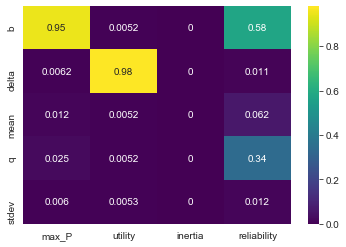

In [78]:
x01LHS = experiments01LHS.loc[:, ["b","delta","stdev","q", "mean", "policy"]]
y01LHS = outcomes01LHS

fs01LHS = feature_scoring.get_feature_scores_all(x01LHS, y01LHS)
sns.heatmap(fs01LHS, cmap='viridis', annot=True)
plt.show()

##### Confidence Interval from LHS

In [79]:
Si01_2 = sobol.analyze(problem01, outcomes01['reliability'],
                   calc_second_order=True, print_to_console=False)

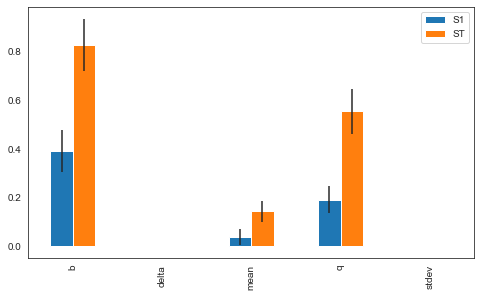

In [80]:
scores_filtered01_2 = {k:Si01_2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si01_2_df = pd.DataFrame(scores_filtered01_2, index=problem01['names'])

sns.set_style('white')
fig, ax01_2 = plt.subplots(1)

indices01_2 = Si01_2_df[['S1','ST']]
err01_2 = Si01_2_df[['S1_conf','ST_conf']]

indices01_2.plot.bar(yerr=err01_2.values.T,ax=ax01_2)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()